In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import re
# os는 파이썬의 내장 모듈 중 하나로, 운영체제와 상호 작용하기 위한 기능을 제공
import os
# shutil은 파일 및 디렉토리 작업을 위한 파이썬의 내장 모듈 중 하나
import shutil
# glob은 파일 경로를 패턴 매칭을 통해 검색하는데 사용되는 파이썬의 내장 모듈 중 하나
import glob
import zipfile
import cv2


# 1.데이터 통합 및 전처리

In [7]:
path = "/Users/jinwo/OneDrive/바탕 화면/골연령데이터/BondAge/"
data_path = "/Users/jinwo/OneDrive/바탕 화면/골연령데이터/Data/"

#xlsx파일과 zip파일 경로 추출
xls_path = glob.glob(path+"*.xlsx")
zip_path = glob.glob(path+"*.zip")

## 1.1 이미지 통합

In [8]:
#zip파일 압축 해제 후 위치 변경
for zip in zip_path:
    zipfile.ZipFile(zip).extractall(data_path + "Images")

In [9]:
#이중 폴더 내 이미지 꺼내기
infolder_path = glob.glob(data_path+"Images"+"/BA*")
for in_path in infolder_path:
    tmp=os.listdir(in_path)
    for i in tmp:
        #파일 이름에서 앞의 0 제거
        processed_name = i.lstrip("0")

        #파일 이동 및 이름 변경
        os.rename(os.path.join(in_path, i), os.path.join(data_path + "Images", processed_name))
    
    os.rmdir(in_path)

In [10]:
#남녀 이미지 분류, 새로운 이미지 폴더 생성 후 복사
image_folder_path = os.path.join(data_path, "Images")
output_folder_m = os.path.join(data_path, "Images_M")
output_folder_f = os.path.join(data_path, "Images_F")

#출력 폴더 생성
os.makedirs(output_folder_m, exist_ok=True)
os.makedirs(output_folder_f, exist_ok=True)

#이미지 파일 분류
image_files = glob.glob(os.path.join(image_folder_path, "*.jpg"))

for image_file in image_files:
    #파일 이름에서 Gender 추출
    gender = os.path.basename(image_file).split("_")[-1]
   
    #새로운 경로 생성
    output_folder = output_folder_m if gender == "M.jpg" else output_folder_f
    output_path = os.path.join(output_folder, os.path.basename(image_file))

    #이미지 복사
    shutil.copy(image_file, output_path)


## 1.2 xlsx 데이터 통합

In [11]:
#xlsx파일 읽어서 합치기
df = pd.DataFrame()
for xlsx in xls_path:
    sub = pd.read_excel(xlsx)
    
    id = pd.DataFrame([int(re.findall(r'\d+', str(x))[0]) for x in sub["No."]])
    gender = sub["성별"].map({2: "F", 1: "M"})
    ba = (sub["BA 1"] + sub["BA 2"]) / 2
    
    tmp = pd.concat([id, gender, ba], axis=1, ignore_index=True)
    df = pd.concat([df, tmp], axis=0, ignore_index=True)

df.columns = ["ID","Gender","BondAge"]

#labeling 데이터 xlsx파일로 저장
#df.to_excel(data_path + "merge_data.xlsx")

#ID컬럼을 오름차순으로 정렬
sorted_df = pd.concat([
    df[df['Gender'] == 'F'].sort_values(by=['ID']).reset_index(drop=True),
    df[df['Gender'] == 'M'].sort_values(by=['ID']).reset_index(drop=True)
], ignore_index=True)

#labeling 데이터 csv파일로 저장
#sorted_df.to_csv(data_path + "merge_data.csv")


In [12]:
sorted_df.head()

,ID,Gender,BondAge
0,1,F,3.250
1,2,F,1.750
2,3,F,2.375
3,4,F,2.250
4,5,F,4.000


In [13]:
#중복된 ID값 찾기
duplicate_ids_sorted = sorted_df[sorted_df.duplicated('ID')]

if duplicate_ids_sorted.empty:
    print("중복된 ID 값이 없습니다.")
else:
    print("중복된 ID 값이 있습니다.")
    print(duplicate_ids_sorted)

중복된 ID 값이 있습니다.
       ID Gender  BondAge
114   114      F    5.500
268   268      F   10.125
572     1      M    4.125
573     2      M    2.625
574     3      M    4.250
...   ...    ...      ...
1138  567      M   14.125
1139  568      M   15.625
1140  569      M   15.000
1141  570      M   13.125
1142  571      M   15.625

[572 rows x 3 columns]


In [14]:
#ID가 중복된 행 확인하기
all_duplicate_rows_114_F = sorted_df[(sorted_df['ID'] == 114) & (sorted_df['Gender'] == 'F')]
print("ID가 114이고 Gender가 F인 모든 중복된 행:")
print(all_duplicate_rows_114_F)

all_duplicate_rows_268_F = sorted_df[(sorted_df['ID'] == 268) & (sorted_df['Gender'] == 'F')]
print("ID가 268이고 Gender가 F인 모든 중복된 행:")
print(all_duplicate_rows_268_F)

all_duplicate_rows_185_M = sorted_df[(sorted_df['ID'] == 185) & (sorted_df['Gender'] == 'M')]
print("ID가 185이고 Gender가 M인 모든 중복된 행:")
print(all_duplicate_rows_185_M)

ID가 114이고 Gender가 F인 모든 중복된 행:
      ID Gender  BondAge
113  114      F    5.375
114  114      F    5.500
ID가 268이고 Gender가 F인 모든 중복된 행:
      ID Gender  BondAge
267  268      F    9.000
268  268      F   10.125
ID가 185이고 Gender가 M인 모든 중복된 행:
      ID Gender  BondAge
756  185      M     6.25
757  185      M     7.50


In [15]:
# ID가 114 또는 268이고 Gender가 'F'인 행 삭제
indexes_to_remove_114 = sorted_df[(sorted_df['ID'].isin([114])) & (sorted_df['Gender'] == 'F') & (sorted_df['BondAge'].isin([5.500]))].index
sorted_df.drop(indexes_to_remove_114, inplace=True)

indexes_to_remove_268 = sorted_df[(sorted_df['ID'].isin([268])) & (sorted_df['Gender'] == 'F') & (sorted_df['BondAge'].isin([10.125]))].index
sorted_df.drop(indexes_to_remove_268, inplace=True)

# ID가 185이고 Gender가 'M'인 행의 ID 값을 186으로 변경
sorted_df.loc[(sorted_df['ID'] == 185) & (sorted_df['Gender'] == 'M') & (sorted_df['BondAge'].isin([6.25])), 'ID'] = 186

#labeling 데이터 xlsx파일로 저장
sorted_df.to_excel(data_path + "[excel]merge_data.xlsx")

#labeling 데이터 csv파일로 저장
sorted_df.to_csv(data_path + "merge_data.csv")

In [17]:
sorted_df

,ID,Gender,BondAge
0,1,F,3.250
1,2,F,1.750
2,3,F,2.375
3,4,F,2.250
4,5,F,4.000
...,...,...,...
1232,661,M,16.500
1233,662,M,16.500
1234,663,M,15.875
1235,664,M,17.000


## 1.3 train, test set 분리

In [19]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(sorted_df, test_size=0.2, random_state=42, stratify=sorted_df["Gender"])
train_df.to_csv(data_path + "train_df.csv", index=False)
test_df.to_csv(data_path + "test_df.csv", index=False)


In [31]:
train_id = train_df["ID"].values.tolist()
test_id = test_df["ID"].values.tolist()

#train_image 와 test_image 폴더 생성
data_path = "/Users/jinwo/OneDrive/바탕 화면/골연령데이터/Data/"
train_image_folder = os.path.join(data_path, "train_Images")
test_image_folder = os.path.join(data_path, "test_Images")

os.makedirs(train_image_folder, exist_ok=True)
os.makedirs(test_image_folder, exist_ok=True)

In [ ]:
## 진행해야 할 사항
# 1. 데이터 통합 다시
# 2. train, test 이미지 분리

# 2.이미지 전처리

## 2.1 이미지 불러오고 사이즈 수정

이미지 데이터 타입: uint8


Text(0.5, 1.0, 'Resized Image')

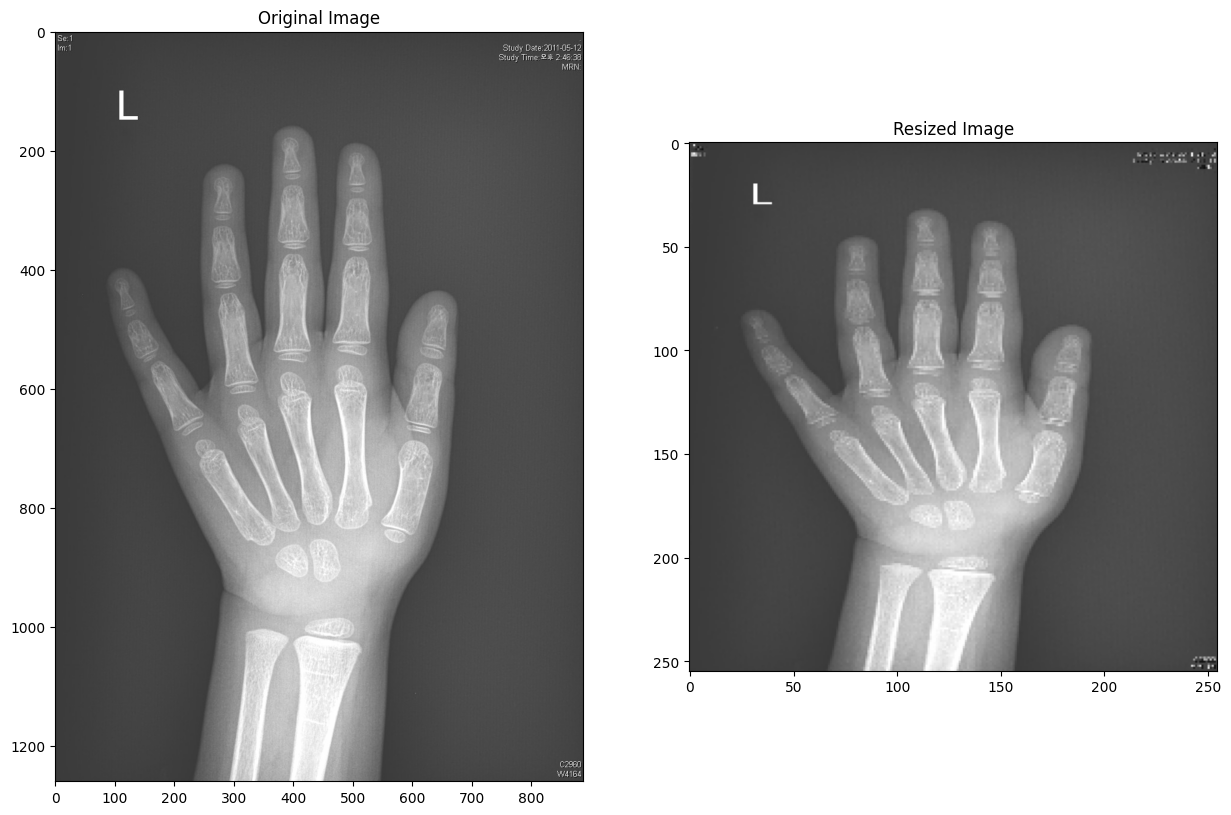

In [8]:
img_path = "/Users/jinwo/OneDrive/바탕 화면/골연령데이터/Data/Images/"
img_sample = plt.imread(img_path + "14_F.jpg", cv2.IMREAD_GRAYSCALE)

#이미지 데이터 타입 확인
print("이미지 데이터 타입:", img_sample.dtype)

#이미지 사이즈 수정
resized_img=cv2.resize(img_sample, (255, 255))

#이미지 확인
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(img_sample, "gray")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(resized_img, "gray")
plt.title("Resized Image")

## 2.2 이미지 정규화 및 노이즈 제거

In [9]:
# <이미지 전처리>
# 이미지 회전
# 이미지 노이즈 제거
# 이미지 평탄화
# 이미지 이진화
# 이미지 256x256으로 이미지 사이즈 통일
# 이미지 무게 중심 구하기
# 좌표를 사용해 ROI 지정
# 추출된 roi와 직접 드래그 한 roi의 iou 측정
# 추출된 roi를 디렉터리에 저장 -> 성별로 구분
# 저장된 roi를 통해 모델 학습 시작


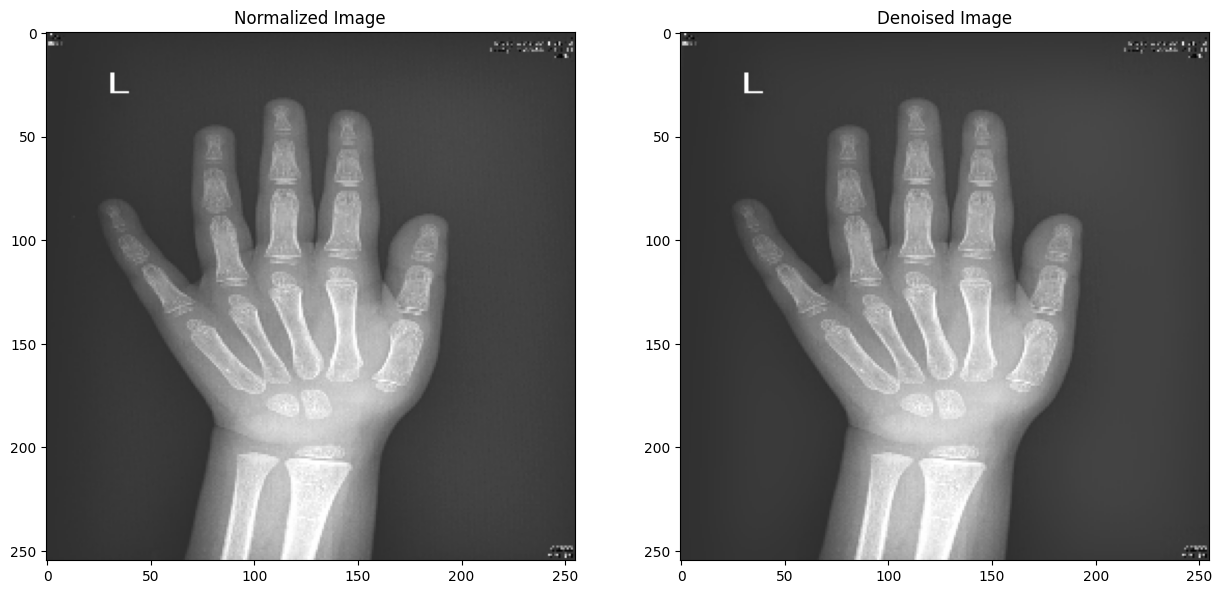

In [19]:
#이미지 정규화(Normalize)
#이미지 정규화는 이미지의 각 픽셀 값을 정해진 범위로 조절하는 과정이다. 주로 0에서 1사이의 값으로 정규화하는 것이 일반적이다.
normalized_image = cv2.normalize(resized_img, None, 0, 255, cv2.NORM_MINMAX)

#노이즈 제거(Denoise)
# h : 필터 강도. 값이 작을수록 노이즈 제거가 더 강하게 적용.
# templateWindowSize : 비교 윈도우 크기. 큰 값은 노이즈 제거를 강화하지만 계산 비용이 더 많이 듦.
# searchWindowSize : 이웃 픽셀을 검색하는 윈도우의 크기. 큰 값일수록 좋지만 계산 비용이 더 많이 듦.
denoised_image = cv2.fastNlMeansDenoising(normalized_image, None, h=1, templateWindowSize=21, searchWindowSize=30)

#결과 비교
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(normalized_image, cmap="gray")
plt.title("Normalized Image")

plt.subplot(1, 2, 2)
plt.imshow(denoised_image, cmap="gray")
plt.title("Denoised Image")

plt.show()

## 2.3 이미지 평탄화 및 이진화

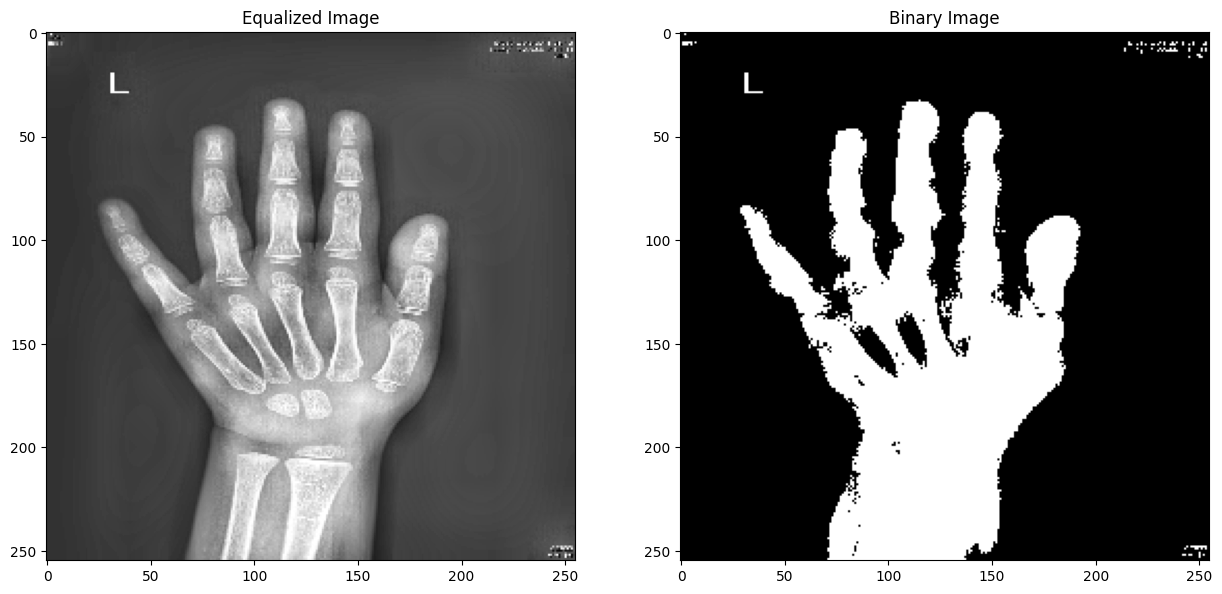

In [17]:
#이미지 평탄화(Contrast Stretching)
#이미지 평탄화는 이미지의 전체적인 대비를 향상시키는 기술이다. 히스토그램을 이용하여 이미지의 밝기 범위를 조절한다.
gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
equalized_image = clahe.apply(gray_image)

#이미지 이진화(Binarization)
#이진화는 이미지를 흑백 두 가지 값으로 변환하는 작업이다. 특정 임계값 이상은 흰색, 이하는 검은색으로 설정한다.
_, binary_image = cv2.threshold(equalized_image, 127, 255, cv2.THRESH_BINARY)

# 결과 비교
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Image')

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')

plt.show()
